In [1]:
# from azureml.core import Workspace, Dataset, Datastore

# subscription_id = '23a8a631-0604-4fee-8ab5-27d6a59ff9dd'
# resource_group = 'PASREVDEV-east'
# workspace_name = 'pasrevamldevhkwx'

# workspace = Workspace(subscription_id, resource_group, workspace_name)

# datastore = Datastore.get(workspace, "jade_batch_input")
# dataset = Dataset.File.from_files(path=(datastore, 'input_20231220/testing_trails_hf_file.parq'))
# dataset.download(target_path='.', overwrite=True)

In [2]:
# !pip install lxml

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from pyarrow.parquet import ParquetFile
import pyarrow as pa 

pf = ParquetFile('testing_trails_hf_file.parq') 
first_ten_rows = next(pf.iter_batches(batch_size = 100)) 
df = pa.Table.from_batches([first_ten_rows]).to_pandas() 

In [3]:
df.shape

(100, 26)

In [4]:
cnt = 0
for i in df["data_notes"]:
    print(i)
    cnt += 1
    if cnt == 15:
        break

Cast Room Procedure Note    Diagnosis:   1. Closed avulsion fracture of phalanx of left thumb, initial encounter            The patient was properly identified using two unique identifiers.  Informed consent was provided by the patient.  A time out was performed to confirm the site and side of the procedure.  The patient and all members of the treatment team were in agreement.    Site/Side:  Left Upper Extremity    Procedure:   Cast/Splint Application    Type:  Short Arm Thumb Spica    Medical Equipment Given:   None    Cast care instructions were provided. Patient demonstrates understanding via teach-back method.    Discharged to: Home    Discharged per: Ambulatory    Accompanied by: Self       Per order, I applied a left thumb spica cast.  Good cap refill and CMS.  Patient was educated about the cast and cast care.
"""This text based report may not contain images, tables or some formatting contained in the full report.  Please review the full report to see all relevant information"" 

In [4]:
df.head()

,patient_mrn,first_name,last_name,dob,gender,patient_race,epi_id,document_id,source_system,document_status,...,pos_type,patient_class,contact_type,facility_id,facility_name,location,admission_date,discharge_date,source_key,newline
0,64094877,Mariana,Mendez,2005-03-02 00:00:00.000,Female,Other,E6868484,3603501852,None,Signed,...,Off Campus - Outpatient Hospital,Outpatient,Office Visit,101121,HFHN DETROIT PISTONS PERFORMANCE CENTER,DPPC ORTHOPAEDICS,2023-04-21 08:00:00.000,2023-04-21 08:00:00.000,393AD70D2876375D04B2C75C3614EA26F66C1F81A38761...,\n
1,62560816,Mark,McKaney,1962-02-04 00:00:00.000,Male,Black,E5101818,740082714,HENRY FORD HOSPITAL LABORATORY,Final result,...,On Campus - Outpatient Hospital,Inpatient,Hospital Encounter,112001,HFAH ALLEGIANCE HOSPITAL,HFAH 7S MED SURG,2023-02-03 13:28:00.000,2023-02-13 16:14:00.000,393AD70E519E2F72575B9BE031E8AC1864EAF71021657A...,\n
2,61575856,Connie,Ravezzani,1967-05-28 00:00:00.000,Female,White,E3906971,3546773173,None,Signed,...,On Campus - Outpatient Hospital, ,Telephone,101001,HFHN HENRY FORD HOSPITAL,DETC NEUROLOGY,2023-03-23 00:00:00.000,2023-03-23 00:00:00.000,393AD82E5543B4B2AFA8D88714143B6908B3C9D8225F54...,\n
3,32687684,Laura,Chaluleu,1953-08-23 00:00:00.000,Female,White,E1331003,3566014063,None,Signed,...,On Campus - Outpatient Hospital,Outpatient,Office Visit,101001,HFHN HENRY FORD HOSPITAL,DETC SURGICAL OPTIMIZATION CLINIC,2023-04-03 10:45:00.000,2023-04-03 10:45:00.000,393AD8535059D72B61B956F85D33E05909281366173534...,\n
4,30877233,Andrew,Bissonette,1980-05-22 00:00:00.000,Male,White,E1064927,3541760026,None,Signed,...,On Campus - Outpatient Hospital,Outpatient Surgery,Hospital Encounter,101001,HFHN HENRY FORD HOSPITAL,HFH PERI OP,2023-04-14 10:44:00.000,2023-04-14 16:33:00.000,393AD9334AE3C67916FA6E1928FCF4DB7426208EFE322C...,\n


In [7]:
df.columns

Index(['patient_mrn', 'first_name', 'last_name', 'dob', 'gender',
       'patient_race', 'epi_id', 'document_id', 'source_system',
       'document_status', 'created', 'modified', 'document_type', 'data_notes',
       'deceased', 'date_of_death', 'pos_type', 'patient_class',
       'contact_type', 'facility_id', 'facility_name', 'location',
       'admission_date', 'discharge_date', 'source_key', 'newline'],
      dtype='object')

In [8]:
df_fil = df[["data_notes","document_type","source_key"]]

In [9]:
print(df_fil["document_type"].nunique())

981


In [10]:
print(df_fil["document_type"].unique())

['Progress Notes' 'SURGICAL SPECIMEN EXAM - Result Note'
 'Telephone Encounter' 'PAT Notes' 'Procedures'
 'Anesthesia Procedure Notes' 'ED Notes' 'Discharge Summary'
 'General Note' 'ED Procedure Note' 'Brief Op Note'
 'ECG 12-LEAD - Result Note' 'Face to Face'
 'CT HEAD W WO IV CONTRAST - Result Note' 'PET-CT ONCOLOGIC - Result Note'
 'Plan of Care' 'Anesthesia Postprocedure Evaluation' 'H&P'
 'ANTERIOR SEGMENT OCT - OU - BOTH EYES - Result Note'
 'IP CM Payor Communication' 'Consults' 'OR Nursing' 'ED Provider Notes'
 'LUMBAR SACRAL SPINE 2 OR 3 VIEWS (ROUTINE) - Result Note'
 'Transfer of Care' 'MRI CERVICAL SPINE WO CONTRAST - Result Note'
 'Advance Care Planning' 'CHEST 2 VIEWS (ROUTINE) - Result Note'
 'ABDOMEN 1 VIEW KUB - Result Note'
 'CHEST 1 VIEW (INCLUDING PORTABLE) - Result Note' 'Addendum Note'
 'Interval H&P Note' 'HAND LEFT MIN 3 VIEWS (ROUTINE) - Result Note'
 'Critical Care' 'ECHOCARDIOGRAM - Result Note'
 'DIGITAL BREAST TOMOSYNTHESIS, DBT, SCREENING BIL MAMMOGRAM - 

In [11]:
df_results = df_fil[~df_fil["document_type"].str.contains("Result Note")]
df_results = df_results.drop_duplicates("document_type")

In [12]:
df_results["document_type"].nunique()

72

In [13]:
for i in df_results["document_type"]:
    print(i)

Progress Notes
Telephone Encounter
PAT Notes
Procedures
Anesthesia Procedure Notes
ED Notes
Discharge Summary
General Note
ED Procedure Note
Brief Op Note
Face to Face
Plan of Care
Anesthesia Postprocedure Evaluation
H&P
IP CM Payor Communication
Consults
OR Nursing
ED Provider Notes
Transfer of Care
Advance Care Planning
Addendum Note
Interval H&P Note
Critical Care
Op Note
Preliminary Diagnostic Procedure Note
Hospital Course
ED Progress Note
Anesthesia Preprocedure Evaluation
Restraint Face to Face:  Non-Violent
Substance Use Intervention
Patient Education
Patient Family Meeting
End of Life Discussion
Anesthesia Pain Rounds Notes
IP CM Referral Request
Code Documentation
Rapid Response Note
Treatment Plan
L&D Delivery Note
Care Coordination
Discharge Med Cost Inquiry Note
Sepsis Reassessment Note
Face  to Face
Patient Care Conference
Assessment
Hospice Plan of Care
Medical/APP Student Note
Lactation Note
ED Attestation Note
E-Consult
ID OPAT
LOS/Outlier Physician Certification
Misce

***

## Doc2Vec Classifier

In [14]:
ls_docty = ["Progress Notes","Discharge Summary","H&P","Critical Care","Lactation Note","Op Note","Cancer Care Assessment","End of Life Discussion"]

In [15]:
df_filter = df_fil[df_fil["document_type"].isin(ls_docty)]

In [16]:
df_filter.shape

(31119, 3)

In [17]:
df_filter.isnull().sum()

data_notes       8
document_type    0
source_key       0
dtype: int64

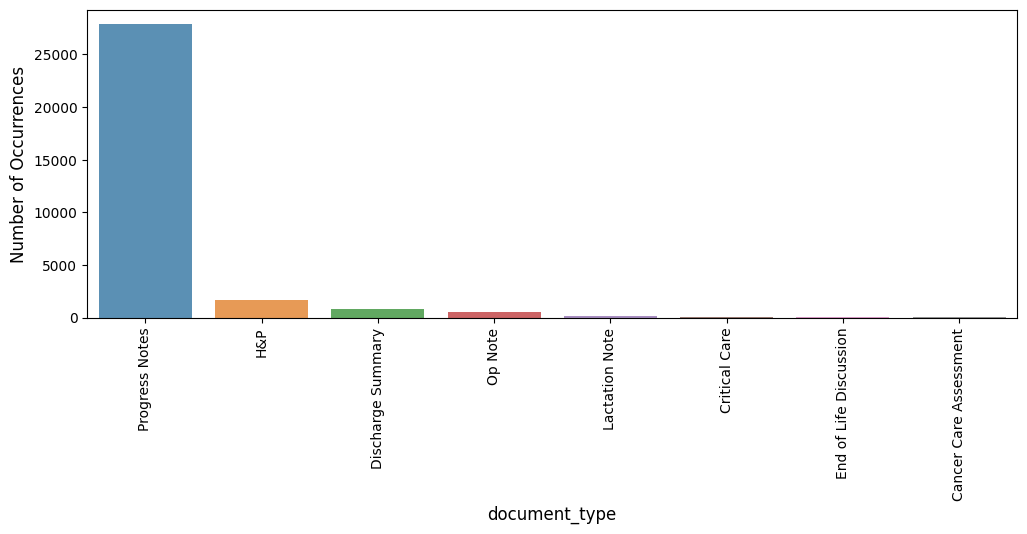

In [18]:
cnt_pro = df_filter['document_type'].value_counts()

plt.figure(figsize=(12,4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('document_type', fontsize=12)
plt.xticks(rotation=90)
plt.show();

### Text Preprocessing

In [19]:
from bs4 import BeautifulSoup
def cleanText(text):
    try:
        text = BeautifulSoup(text, "lxml").text
        text = re.sub(r'\|\|\|', r' ', text) 
        text = re.sub(r'http\S+', r'<URL>', text)
        text = text.lower()
        text = text.replace('x', '')   
        return text
    except:
        return ""

In [20]:
df_filter['new_data_notes'] = df_filter['data_notes'].apply(cleanText)

/tmp/ipykernel_18877/2036159970.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text
/tmp/ipykernel_18877/919789092.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filter['new_data_notes'] = df_filter['data_notes'].apply(cleanText)


In [21]:
df_filter.head()

,data_notes,document_type,source_key,new_data_notes
0,Cast Room Procedure Note Diagnosis: 1. Cl...,Progress Notes,393AD70D2876375D04B2C75C3614EA26F66C1F81A38761...,cast room procedure note diagnosis: 1. cl...
3,Preoperative Consultation by Department of An...,Progress Notes,393AD8535059D72B61B956F85D33E05909281366173534...,preoperative consultation by department of an...
11,Physical Therapy Daily Note Date of Service...,Progress Notes,393AE97F429824791B81C796ECC6E6CE24F8145353B20B...,physical therapy daily note date of service...
12,"Blood pressure of 149/78 was after napping, im...",Progress Notes,393AEA7B5975911AE44B02B0578557E3C9CEAB71F6EC0A...,"blood pressure of 149/78 was after napping, im..."
14,Discharge Summary Discharge information ...,Discharge Summary,393AED4342E3A59DD553F085E3D26EE97A4CF14AFBCEF3...,discharge summary discharge information ...


In [25]:
print(df_filter.shape)
df_filter.index = range(31119)

(31119, 4)


***
### DBOW (Distributed Bag of Words)

In [26]:
from gensim.models import doc2vec

def label_sentences(corpus, label_type):
    labeled = []
    for i, v in enumerate(corpus):
        label = label_type + '_' + str(i)
        labeled.append(doc2vec.TaggedDocument(v.split(), [label]))
    return labeled

Split the dataframe

In [27]:
X_train, X_test, y_train, y_test = train_test_split(df_filter.new_data_notes, df_filter.document_type, random_state=0, test_size=0.3)
X_train = label_sentences(X_train, 'Train')
X_test = label_sentences(X_test, 'Test')
all_data = X_train + X_test

In [28]:
all_data[:2]

[TaggedDocument(words=['subjective:', 'history', 'was', 'provided', 'by', 'the', 'mother', 'and', 'father.', 'malaysia', 'jeter', 'is', 'a', '4', 'y.o.', 'female', 'who', 'is', 'brought', 'in', 'for', 'this', 'well-child', 'visit.', 'interval', 'history:', 'parent', 'denies', 'any', 'changes', 'in', 'medical', 'history', 'since', 'previous', 'visit', 'recent', 'ed', 'visits/hospital', 'admissions:', 'none', 'the', 'following', 'portions', 'of', 'the', "patient's", 'history', 'were', 'reviewed', 'and', 'updated', 'as', 'appropriate:', 'allergies,', 'current', 'medications,', 'past', 'family', 'history,', 'past', 'medical', 'history,', 'past', 'social', 'history,', 'past', 'surgical', 'history', 'and', 'problem', 'list.', 'medical', 'history:', 'immunization', 'history', 'administered', 'date(s)', 'administered', 'dtap', '05/03/2019,', '02/09/2021', 'dtap', '/', 'hep', 'b', '/', 'ipv', '11/08/2019', 'dtap', '/', 'hib', '/', 'ipv', '02/20/2019', 'hib', '(pedvahib)', '05/03/2019,', '12/20/

In [29]:
model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
model_dbow.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 31119/31119 [00:00<00:00, 2789956.74it/s]


In [30]:
%%time
for epoch in range(30):
    model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dbow.alpha -= 0.002
    model_dbow.min_alpha = model_dbow.alpha

100%|██████████| 31119/31119 [00:00<00:00, 3214761.86it/s]


CPU times: user 25min 5s, sys: 8.93 s, total: 25min 14s
Wall time: 8min 56s


In [31]:
def get_vectors(model, corpus_size, vectors_size, vectors_type):
    """
    Get vectors from trained doc2vec model
    :param doc2vec_model: Trained Doc2Vec model
    :param corpus_size: Size of the data
    :param vectors_size: Size of the embedding vectors
    :param vectors_type: Training or Testing vectors
    :return: list of vectors
    """
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = model.docvecs[prefix]
    return vectors

In [32]:
train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

Logistic Regression

In [33]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(multi_class='multinomial', solver = 'lbfgs')
logreg.fit(train_vectors_dbow, y_train)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [34]:
logreg.score(test_vectors_dbow, y_test)

0.9801842330762639

***

### Distributed Memory

In [75]:
model_dm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dm.build_vocab([x for x in tqdm(all_data)])

100%|██████████| 31119/31119 [00:00<00:00, 3331611.56it/s]


In [76]:
%%time
for epoch in range(30):
    model_dm.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
    model_dm.alpha -= 0.002
    model_dm.min_alpha = model_dm.alpha

100%|██████████| 31119/31119 [00:00<00:00, 3477911.65it/s]


CPU times: user 38min 47s, sys: 24.2 s, total: 39min 11s
Wall time: 9min 15s


In [77]:
train_vectors_dm = get_vectors(model_dm, len(X_train), 300, 'Train')
test_vectors_dm = get_vectors(model_dm, len(X_test), 300, 'Test')

In [78]:
logreg.fit(train_vectors_dm, y_train)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
logreg.score(test_vectors_dm, y_test)

0.9187017994858612

In [80]:
model_dm.save('d2v_model_dm.doc2vec')

In [81]:
# model_dbow = Doc2Vec.load('d2v_model_dbow.doc2vec')
# model_dm = Doc2Vec.load('d2v_model_dm.doc2vec')
model_dbow.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
model_dm.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)

In [82]:
def get_concat_vectors(model1,model2, corpus_size, vectors_size, vectors_type):
    vectors = np.zeros((corpus_size, vectors_size))
    for i in range(0, corpus_size):
        prefix = vectors_type + '_' + str(i)
        vectors[i] = np.append(model1.docvecs[prefix],model2.docvecs[prefix])
    return vectors

In [83]:
train_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_train), 600, 'Train')
test_vecs_dbow_dm = get_concat_vectors(model_dbow,model_dm, len(X_test), 600, 'Test')

In [84]:
%%time
logreg = LogisticRegression()
logreg.fit(train_vecs_dbow_dm, y_train)

CPU times: user 22.9 s, sys: 7.14 s, total: 30 s
Wall time: 3.88 s


/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [85]:
logreg.score(test_vecs_dbow_dm, y_test)

0.9736503856041131